In [1]:
#import libraries
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib
from matplotlib import pyplot
%matplotlib inline
import numpy

Using TensorFlow backend.


In [2]:
import glob
from keras.layers import Dropout

In [3]:
import pandas as pd
reading_dates=pd.date_range('2011-01-01',freq='W',periods=28)
print(reading_dates)

DatetimeIndex(['2011-01-02', '2011-01-09', '2011-01-16', '2011-01-23',
               '2011-01-30', '2011-02-06', '2011-02-13', '2011-02-20',
               '2011-02-27', '2011-03-06', '2011-03-13', '2011-03-20',
               '2011-03-27', '2011-04-03', '2011-04-10', '2011-04-17',
               '2011-04-24', '2011-05-01', '2011-05-08', '2011-05-15',
               '2011-05-22', '2011-05-29', '2011-06-05', '2011-06-12',
               '2011-06-19', '2011-06-26', '2011-07-03', '2011-07-10'],
              dtype='datetime64[ns]', freq='W-SUN')


In [4]:
#load denoised QoS ts
files=glob.glob("csv_denoised/*.csv")
data=[]
names=[]
for file in files:
    df=read_csv(file,header=0,names=['Av','Mx_rt','Mn_rt','Avg_rt','th'])
    df['R_dates']=reading_dates
    df=df.set_index('R_dates')
    names.append(file)
    df.drop(df.columns[[1,2]], axis=1, inplace=True)
    data.append(df)

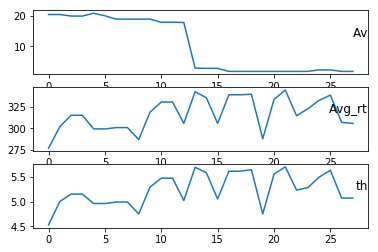

In [5]:
values=data[65].values
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data[50].columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [6]:
len(data)

95

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    #n_in number of lag observations
    #n_out number of next observations
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:

#reframed.drop(reframed.columns[[5,6,7,8]], axis=1, inplace=True)

In [9]:
#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
values = data[0].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 8, 4)
# frame as supervised learning
reframed = series_to_supervised(scaled, 4, 4)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[5,6,7,8]], axis=1, inplace=True)
print(reframed.head())
# drop columns we don't want to predict

   var1(t-4)  var2(t-4)  var3(t-4)  var1(t-3)  var2(t-3)  var3(t-3)  \
4   0.040000   0.509872   0.494253   0.028409   0.509872   0.494253   
5   0.028409   0.509872   0.494253   0.022727   0.667644   0.620690   
6   0.022727   0.667644   0.620690   0.022727   0.527859   0.517241   
7   0.022727   0.527859   0.517241   0.005682   0.801564   0.632184   
8   0.005682   0.801564   0.632184   0.017273   0.804496   0.689655   

   var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)    ...       var3(t)  var1(t+1)  \
4   0.022727   0.667644   0.620690   0.022727    ...      0.632184   0.017273   
5   0.022727   0.527859   0.517241   0.005682    ...      0.689655   0.040000   
6   0.005682   0.801564   0.632184   0.017273    ...      0.344828   0.028409   
7   0.017273   0.804496   0.689655   0.040000    ...      0.436782   0.022727   
8   0.040000   0.332355   0.344828   0.028409    ...      0.183908   0.022727   

   var2(t+1)  var3(t+1)  var1(t+2)  var2(t+2)  var3(t+2)  var1(t+3)  \
4   0.804496   

In [10]:
reframed

,var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),...,var3(t),var1(t+1),var2(t+1),var3(t+1),var1(t+2),var2(t+2),var3(t+2),var1(t+3),var2(t+3),var3(t+3)
4,0.040000,0.509872,0.494253,0.028409,0.509872,0.494253,0.022727,0.667644,0.620690,0.022727,...,0.632184,0.017273,0.804496,0.689655,0.040000,0.332355,0.344828,0.028409,0.589443,0.436782
5,0.028409,0.509872,0.494253,0.022727,0.667644,0.620690,0.022727,0.527859,0.517241,0.005682,...,0.689655,0.040000,0.332355,0.344828,0.028409,0.589443,0.436782,0.022727,0.159335,0.183908
6,0.022727,0.667644,0.620690,0.022727,0.527859,0.517241,0.005682,0.801564,0.632184,0.017273,...,0.344828,0.028409,0.589443,0.436782,0.022727,0.159335,0.183908,0.022727,0.156403,0.160919
7,0.022727,0.527859,0.517241,0.005682,0.801564,0.632184,0.017273,0.804496,0.689655,0.040000,...,0.436782,0.022727,0.159335,0.183908,0.022727,0.156403,0.160919,0.000000,0.469208,0.344828
8,0.005682,0.801564,0.632184,0.017273,0.804496,0.689655,0.040000,0.332355,0.344828,0.028409,...,0.183908,0.022727,0.156403,0.160919,0.000000,0.469208,0.344828,0.000000,0.863147,0.793104
9,0.017273,0.804496,0.689655,0.040000,0.332355,0.344828,0.028409,0.589443,0.436782,0.022727,...,0.160919,0.000000,0.469208,0.344828,0.000000,0.863147,0.793104,0.244546,0.117302,0.103448
10,0.040000,0.332355,0.344828,0.028409,0.589443,0.436782,0.022727,0.159335,0.183908,0.022727,...,0.344828,0.000000,0.863147,0.793104,0.244546,0.117302,0.103448,0.232955,1.000000,1.000000
11,0.028409,0.589443,0.436782,0.022727,0.159335,0.183908,0.022727,0.156403,0.160919,0.000000,...,0.793104,0.244546,0.117302,0.103448,0.232955,1.000000,1.000000,0.204545,0.314369,0.229885
12,0.022727,0.159335,0.183908,0.022727,0.156403,0.160919,0.000000,0.469208,0.344828,0.000000,...,0.103448,0.232955,1.000000,1.000000,0.204545,0.314369,0.229885,0.204545,0.314369,0.229885
13,0.022727,0.156403,0.160919,0.000000,0.469208,0.344828,0.000000,0.863147,0.793104,0.244546,...,1.000000,0.204545,0.314369,0.229885,0.204545,0.314369,0.229885,0.204545,0.217986,0.218391


In [11]:
preprocessed_data=[]
for i in (range(len(data))):
    values = data[i].values
    # integer encode direction
    #encoder = LabelEncoder()
    #values[:,4] = encoder.fit_transform(values[:,4])
    # ensure all data is float
    values = values.astype('float32')
# normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled,4, 4)
    # drop columns we don't want to predict
    #reframed.drop(reframed.columns[[5,6,7,8]], axis=1, inplace=True)
    preprocessed_data.append(reframed)

In [12]:
preprocessed_data[0].head()

,var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),...,var3(t),var1(t+1),var2(t+1),var3(t+1),var1(t+2),var2(t+2),var3(t+2),var1(t+3),var2(t+3),var3(t+3)
4,0.040000,0.509872,0.494253,0.028409,0.509872,0.494253,0.022727,0.667644,0.620690,0.022727,...,0.632184,0.017273,0.804496,0.689655,0.040000,0.332355,0.344828,0.028409,0.589443,0.436782
5,0.028409,0.509872,0.494253,0.022727,0.667644,0.620690,0.022727,0.527859,0.517241,0.005682,...,0.689655,0.040000,0.332355,0.344828,0.028409,0.589443,0.436782,0.022727,0.159335,0.183908
6,0.022727,0.667644,0.620690,0.022727,0.527859,0.517241,0.005682,0.801564,0.632184,0.017273,...,0.344828,0.028409,0.589443,0.436782,0.022727,0.159335,0.183908,0.022727,0.156403,0.160919
7,0.022727,0.527859,0.517241,0.005682,0.801564,0.632184,0.017273,0.804496,0.689655,0.040000,...,0.436782,0.022727,0.159335,0.183908,0.022727,0.156403,0.160919,0.000000,0.469208,0.344828
8,0.005682,0.801564,0.632184,0.017273,0.804496,0.689655,0.040000,0.332355,0.344828,0.028409,...,0.183908,0.022727,0.156403,0.160919,0.000000,0.469208,0.344828,0.000000,0.863147,0.793104


In [13]:
type(preprocessed_data)

list

In [14]:
#shape = (2700, 6)

#zeros_array = numpy.zeros(shape)
flatten_data=[]
for sublist in preprocessed_data:
    for item in sublist.values:
        #numpy.append(zeros_array,item)
        #print(type(item))
        #zeros_array.append(item)
        flatten_data.append(item)
flatten_data=numpy.array(flatten_data)

In [15]:
#import itertools
#flattened_list  = list(itertools.chain(*flat_data))
#x=[l.tolist() for l in flat_data]

In [16]:
#numpy.array(flat_data)
#type(flat_data)
print(flatten_data)

[[0.04000008 0.50987244 0.49425268 ... 0.02840912 0.58944273 0.43678188]
 [0.02840912 0.50987244 0.49425268 ... 0.02272731 0.15933514 0.18390799]
 [0.02272731 0.667644   0.62068987 ... 0.02272731 0.15640259 0.16091919]
 ...
 [0.7927656  0.6883343  0.683274   ... 0.16013563 0.6226732  0.6120996 ]
 [0.13036919 0.8324056  0.82562274 ... 0.00941968 0.56862396 0.5551601 ]
 [0.05651844 0.69150656 0.683274   ... 0.00941968 0.6348836  0.62989324]]


In [17]:
print(flatten_data.shape)
#import random
#random.shuffle(flatten_data)
len(flatten_data)

(1995, 24)


1995

In [18]:
#train and test splitting task ==> each provider file fter preprocessing, its shape is 21*24 and (24=3*4+3*4) && 21 due to the series to applying supervised function
train=[]
test=[]
for i in range(len(flatten_data)//21):
    train.append(flatten_data[i*21:i*21+14,:])
    test.append(flatten_data[i*21+14:i*21+21,:])

In [19]:
train=numpy.array(train)
test=numpy.array(test)
train=train.reshape(train.shape[0]*train.shape[1],train.shape[2])
test=test.reshape(test.shape[0]*test.shape[1],test.shape[2])
print(train.shape)
print(test.shape)

(1330, 24)
(665, 24)


In [20]:
# split into train and test sets
#train = flatten_data[:1170,:]
#test = flatten_data[1170:,:]
# split into input and outputs
train_X, train_y = train[:, :12], train[:,12:]
test_X, test_y = test[:, :12], test[:,12:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 4, 3))
test_X = test_X.reshape((test_X.shape[0], 4, 3))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1330, 4, 3) (1330, 12) (665, 4, 3) (665, 12)


In [21]:
from keras import regularizers

In [22]:
# design network
model = Sequential()
#model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)) #,return_sequences=True
#model.add(Dropout(0.60))
model.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.7))
model.add(Dense(12))#,activation="relu",activity_regularizer=regularizers.l1(10e-5)
model.compile(loss='mae', optimizer='adam')  #'mae mse
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                204       
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=7, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1330 samples, validate on 665 samples
Epoch 1/50
 - 4s - loss: 0.3803 - val_loss: 0.2820
Epoch 2/50
 - 3s - loss: 0.2924 - val_loss: 0.2364
Epoch 3/50
 - 3s - loss: 0.2623 - val_loss: 0.2233
Epoch 4/50
 - 3s - loss: 0.2433 - val_loss: 0.2148
Epoch 5/50
 - 3s - loss: 0.2324 - val_loss: 0.2065
Epoch 6/50
 - 2s - loss: 0.2273 - val_loss: 0.2094
Epoch 7/50
 - 2s - loss: 0.2184 - val_loss: 0.2052
Epoch 8/50
 - 3s - loss: 0.2169 - val_loss: 0.2021
Epoch 9/50
 - 3s - loss: 0.2134 - val_loss: 0.2015
Epoch 10/50
 - 3s - loss: 0.2077 - val_loss: 0.2011
Epoch 11/50
 - 2s - loss: 0.2062 - val_loss: 0.1997
Epoch 12/50
 - 2s - loss: 0.2071 - val_loss: 0.1984
Epoch 13/50
 - 2s - loss: 0.2053 - val_loss: 0.1958
Epoch 14/50
 - 2s - loss: 0.2006 - val_loss: 0.1951
Epoch 15/50
 - 4s - loss: 0.2055 - val_loss: 0.1953
Epoch 16/50
 - 3s - loss: 0.2002 - val_loss: 0.1927
Epoch 17/50
 - 4s - loss: 0.2023 - val_loss: 0.1943
Epoch 18/50
 - 2s - loss: 0.1997 - val_loss: 0.1930
Epoch 19/50
 - 2s - loss: 

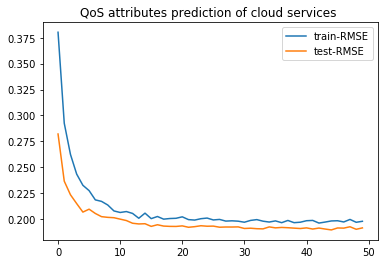

In [24]:
# plot history
pyplot.plot(history.history['loss'], label='train-RMSE')
pyplot.plot(history.history['val_loss'], label='test-RMSE')
pyplot.title("QoS attributes prediction of cloud services ")
pyplot.legend()

pyplot.show()

In [25]:

from math import sqrt
# make a prediction
yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))


In [26]:
# invert scaling for forecast
#20/5=4

inv_yhat1 = scaler.inverse_transform(yhat[:,0:3])
inv_yhat2 = scaler.inverse_transform(yhat[:,3:6])
inv_yhat3 = scaler.inverse_transform(yhat[:,6:9])
inv_yhat4 = scaler.inverse_transform(yhat[:,9:12])
inv_yhat = concatenate((inv_yhat1,inv_yhat2 ), axis=1)
inv_yhat = concatenate((inv_yhat,inv_yhat3 ), axis=1)
inv_yhat = concatenate((inv_yhat,inv_yhat4 ), axis=1)
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y1 = scaler.inverse_transform(test_y[:,0:3])
inv_y2 = scaler.inverse_transform(test_y[:,3:6])
inv_y3 = scaler.inverse_transform(test_y[:,6:9])
inv_y4 = scaler.inverse_transform(test_y[:,9:12])
inv_y = concatenate((inv_y1,inv_y2 ), axis=1)
inv_y = concatenate((inv_y,inv_y3 ), axis=1)
inv_y = concatenate((inv_y,inv_y4 ), axis=1)

In [27]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25.700


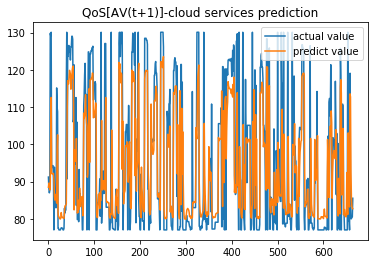

In [28]:
# plot history
pyplot.plot(inv_y[:,0], label='actual value')
pyplot.plot(inv_yhat[:,0], label='predict value')
pyplot.title("QoS[AV(t+1)]-cloud services prediction")
pyplot.legend()
pyplot.show()

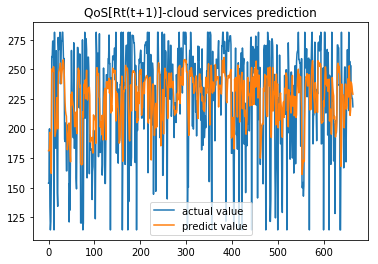

In [29]:
# plot history
pyplot.plot(inv_y[:,1], label='actual value')
pyplot.plot(inv_yhat[:,1], label='predict value')
pyplot.title("QoS[Rt(t+1)]-cloud services prediction")
pyplot.legend()
pyplot.show()

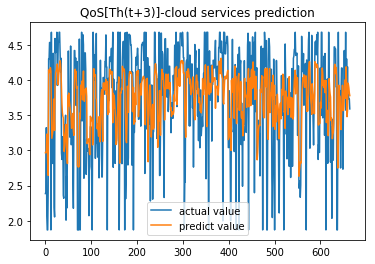

In [30]:
# plot history
pyplot.plot(inv_y[:,2], label='actual value')
pyplot.plot(inv_yhat[:,2], label='predict value')
pyplot.title("QoS[Th(t+3)]-cloud services prediction")
pyplot.legend()
pyplot.show()

In [31]:
results=[]
for i in range(12):
    results.append(sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i])))

In [32]:
QoS_names=['Av','Avg_rt','th']
QoS=[]
QoS_total=[]
for i in range(4):
    QoS=results[i*3:i*3+3]
    QoS_total.append(QoS)
QoS_total=DataFrame(QoS_total)
QoS_total.columns=QoS_names
print(QoS_total)


          Av     Avg_rt        th
0  13.119748  39.574532  0.665847
1  14.463511  41.954661  0.709250
2  15.749193  43.345029  0.729607
3  16.717618  42.543748  0.717419


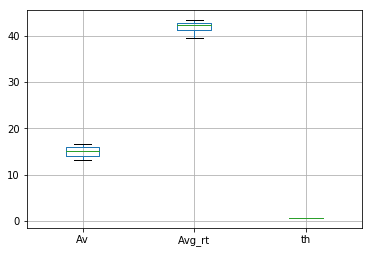

In [33]:
QoS_total[['Av','Avg_rt','th']].boxplot()



In [34]:
# predicted values for each provider
preprocessed_data=[]
for i in range(len(data)):
    values = data[i].values
    values = values.astype('float32')
# normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    scaled=DataFrame(scaled)
    reframed = series_to_supervised(scaled[23:28],4, 0)
    #
    #
    preprocessed_data.append(reframed)

In [35]:
#export predicted values for each provider
predicted_data=[]
for i in range(len(preprocessed_data)):
    temp=numpy.array( preprocessed_data[i])
    temp=temp.reshape((temp.shape[0], 4, 3))
    predict_QoS_Pi=model.predict(temp)
    predict_QoS_Pi=predict_QoS_Pi.reshape(4,3)
    predicted_data.append(predict_QoS_Pi)                #(predicted_data[0][0,0:3])
    df_temp=DataFrame(predict_QoS_Pi)
    df_temp.to_csv('csv_predictions/'+names[i][13:])

In [36]:
names[0][13:]

'service51.csv'

In [37]:
model.save('myModel.h5')

In [38]:
#del model

In [39]:
#from keras.models import load_model

In [40]:
#model=load_model('myModel.h5')

In [41]:
#model.summary()